# Multivariate wasserstein K-Means

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


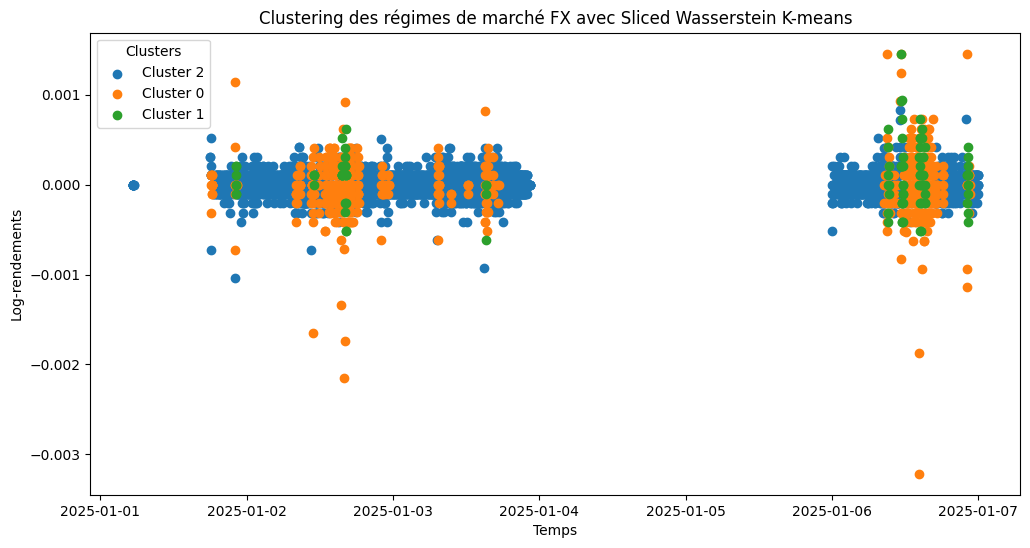

In [ ]:
# Chargement des données de prix à partir de Yahoo Finance
def load_data(ticker, start, end, interval="1m"):
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data = data['Close'].dropna()  # Utiliser les prix de clôture
    return data

# Calculer les rendements logarithmiques
def log_returns(data):
    return np.log(data / data.shift(1)).dropna()

# Calcul de la volatilité réalisée
def realized_volatility(data, window=5):
    return data.rolling(window).std().dropna()

"""
# Fonction de calcul de la distance Wasserstein "sliced"
def sliced_wasserstein_distance(X, Y, n_projections=10):
    directions = np.random.randn(n_projections, X.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, np.newaxis]
    distances = []
    for theta in directions:
        # Projection des données
        X_proj = np.dot(X, theta)
        Y_proj = np.dot(Y, theta)
        # Tri des projections
        X_sorted = np.sort(X_proj)
        Y_sorted = np.sort(Y_proj)
        # Calcul de la distance Wasserstein unidimensionnelle
        distances.append(np.abs(X_sorted - Y_sorted).mean())
    return np.mean(distances)

# Implémentation de l'algorithme Sliced Wasserstein K-means
class SlicedWassersteinKMeans:
    def __init__(self, n_clusters, n_projections=10, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_projections = n_projections
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        # Initialisation des clusters avec KMeans classique pour obtenir les premiers centroids
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(data)
        self.centroids = [np.mean(data[labels == k], axis=0) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = np.mean(cluster_points, axis=0)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])

            new_centroids = np.array(new_centroids)

            # Vérification de la convergence
            shift = np.sum([sliced_wasserstein_distance(self.centroids[i].reshape(1, -1),
                                                        new_centroids[i].reshape(1, -1),
                                                        self.n_projections)
                            for i in range(self.n_clusters)])
            if shift < self.tol:
                break
            self.centroids = new_centroids

            # Réassignation des labels en fonction des nouvelles distances Wasserstein
            labels = np.array([np.argmin([sliced_wasserstein_distance(data[i].reshape(1, -1),
                                                                      self.centroids[j].reshape(1, -1),
                                                                      self.n_projections)
                                          for j in range(self.n_clusters)]) for i in range(len(data))])

        return labels
"""

# Fonction pour créer des fenêtres glissantes
def create_sliding_windows(data, window_size):
    """
    Crée des fenêtres glissantes à partir des données.

    Arguments :
    - data : np.array, les données à découper en fenêtres.
    - window_size : int, taille de chaque fenêtre.

    Retour :
    - np.array contenant les fenêtres glissantes.
    """
    n_windows = len(data) - window_size + 1
    return np.array([data[i:i + window_size] for i in range(n_windows)])

# Fonction de calcul de la distance Wasserstein "sliced"
def sliced_wasserstein_distance(X, Y, n_projections=10):
    directions = np.random.randn(n_projections, X.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, np.newaxis]
    distances = []
    for theta in directions:
        # Projection des données
        X_proj = np.dot(X, theta)
        Y_proj = np.dot(Y, theta)
        # Tri des projections
        X_sorted = np.sort(X_proj)
        Y_sorted = np.sort(Y_proj)
        # Calcul de la distance Wasserstein unidimensionnelle
        distances.append(np.abs(X_sorted - Y_sorted).mean())
    return np.mean(distances)

# Implémentation de l'algorithme Sliced Wasserstein K-means
class SlicedWassersteinKMeans:
    def __init__(self, n_clusters, n_projections=10, max_iter=100, tol=1e-4, window_size=None):
        self.n_clusters = n_clusters
        self.n_projections = n_projections
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.window_size = window_size  # Taille des fenêtres

    def fit(self, data):
        # Créer des fenêtres glissantes si une taille de fenêtre est spécifiée
        if self.window_size:
            data = create_sliding_windows(data, self.window_size)
            data = data.reshape(data.shape[0], -1)  # Aplatir les fenêtres pour le clustering

        # Initialisation des clusters avec KMeans
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        self.centroids = [np.mean(data[labels == k], axis=0) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    # Calcul du barycentre Wasserstein pour chaque cluster
                    centroid = np.mean(cluster_points, axis=0)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])

            new_centroids = np.array(new_centroids)

            # Vérification de la convergence
            shift = np.sum([
                sliced_wasserstein_distance(self.centroids[i].reshape(1, -1),
                                            new_centroids[i].reshape(1, -1),
                                            self.n_projections)
                for i in range(self.n_clusters)
            ])

            if shift < self.tol:
                break

            self.centroids = new_centroids

            # Réassignation des labels
            labels = np.array([
                np.argmin([
                    sliced_wasserstein_distance(data[i].reshape(1, -1),
                                                self.centroids[j].reshape(1, -1),
                                                self.n_projections)
                    for j in range(self.n_clusters)
                ]) for i in range(len(data))
            ])

        return labels


"""
# Paramètres pour les données et le clustering
ticker = "EURUSD=X"
start_date = "2025-01-01"
end_date = "2025-01-07"
interval = "1m"

# Charger les données de prix et calculer les variables
prices = load_data(ticker, start_date, end_date, interval=interval)
log_returns_data = log_returns(prices)
volatility_data = realized_volatility(log_returns_data)

# Aligner les données
combined_data = pd.concat([log_returns_data, volatility_data], axis=1).dropna()
combined_data.columns = ['Log_Returns', 'Volatility']

# Convertir en numpy array
data_for_clustering = combined_data.values

# Application de l'algorithme de sliced Wasserstein K-means sur les données multivariées
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=40)
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajouter les labels au DataFrame
combined_data['Cluster'] = labels

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Tracer les log-rendements avec les clusters colorés
for cluster in combined_data['Cluster'].unique():
    cluster_data = combined_data[combined_data['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Log_Returns'], label=f"Cluster {cluster}")

plt.xlabel("Temps")
plt.ylabel("Log-rendements")
plt.title("Clustering des régimes de marché FX avec Sliced Wasserstein K-means (juste pour les log-rendements)")
plt.legend(title="Clusters")
plt.show()
"""

# Paramètres pour les données et le clustering
ticker = "EURUSD=X"
start_date = "2025-01-01"
end_date = "2025-01-07"
interval = "1m"

# Charger les données de prix et calculer les variables
prices = load_data(ticker, start_date, end_date, interval=interval)
log_returns_data = log_returns(prices)
volatility_data = realized_volatility(log_returns_data)

# Aligner les données
combined_data = pd.concat([log_returns_data, volatility_data], axis=1).dropna()
combined_data.columns = ['Log_Returns', 'Volatility']

# Convertir en numpy array
data_for_clustering = combined_data.values

# Application de l'algorithme de sliced Wasserstein K-means avec fenêtres glissantes
window_size = 15  # Taille de la fenêtre fixée
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=40, window_size=window_size)

# Effectuer le clustering
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Assigner les labels aux fenêtres et répercuter sur les données d'origine
window_timestamps = combined_data.index[window_size - 1:]  # Ajuster les indices pour les fenêtres
combined_data = combined_data.iloc[window_size - 1:]  # Ajuster les données pour correspondre aux fenêtres
combined_data['Cluster'] = labels

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Tracer les log-rendements avec les clusters colorés
for cluster in combined_data['Cluster'].unique():
    cluster_data = combined_data[combined_data['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Log_Returns'], label=f"Cluster {cluster}")

plt.xlabel("Temps")
plt.ylabel("Log-rendements")
plt.title("Clustering des régimes de marché FX avec Sliced Wasserstein K-means")
plt.legend(title="Clusters")
plt.show()


Ici on voit que 0 correspond au régime neutre, 1 à l'achat et 2 à la vente

In [ ]:
combined_data.tail()

,Log_Returns,Volatility,Cluster
Datetime,,,
2025-01-06 23:54:00+00:00,0.000000,0.000127,0
2025-01-06 23:55:00+00:00,0.000104,0.000127,0
2025-01-06 23:56:00+00:00,0.000104,0.000057,0
2025-01-06 23:57:00+00:00,-0.000104,0.000087,0
2025-01-06 23:58:00+00:00,0.000000,0.000087,0


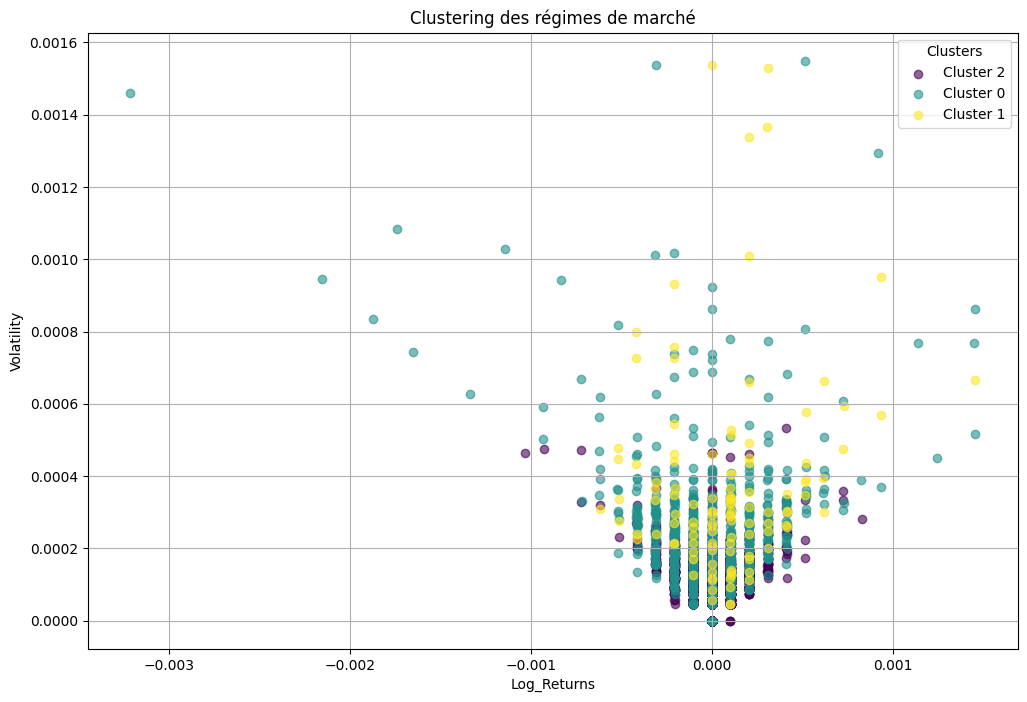

In [ ]:
def visualize_clusters_2d(data, param1, param2, cluster_col='Cluster', title="Visualisation des régimes de marché"):
    """
    Visualise les clusters en 2D à partir de deux paramètres.

    Arguments :
    - data : DataFrame contenant les paramètres et les clusters.
    - param1 : str, nom du premier paramètre (axe x).
    - param2 : str, nom du deuxième paramètre (axe y).
    - cluster_col : str, nom de la colonne des clusters (par défaut 'Cluster').
    - title : str, titre du graphique.

    Retour :
    - Affiche un graphique en 2D des paramètres colorés par cluster.
    """
    plt.figure(figsize=(12, 8))

    # Obtenir les clusters uniques
    unique_clusters = data[cluster_col].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

    # Tracer chaque cluster
    for idx, cluster in enumerate(unique_clusters):
        cluster_data = data[data[cluster_col] == cluster]
        plt.scatter(
            cluster_data[param1],
            cluster_data[param2],
            color=colors[idx],
            label=f"Cluster {cluster}",
            alpha=0.6
        )

    # Ajouter des détails au graphique
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.title(title)
    plt.legend(title="Clusters")
    plt.grid(True)
    plt.show()

# Visualiser les clusters sur les log-rendements et la volatilité
visualize_clusters_2d(
    data=combined_data,
    param1='Log_Returns',
    param2='Volatility',
    cluster_col='Cluster',
    title="Clustering des régimes de marché"
)

## Essayons plusieurs types d'affichages

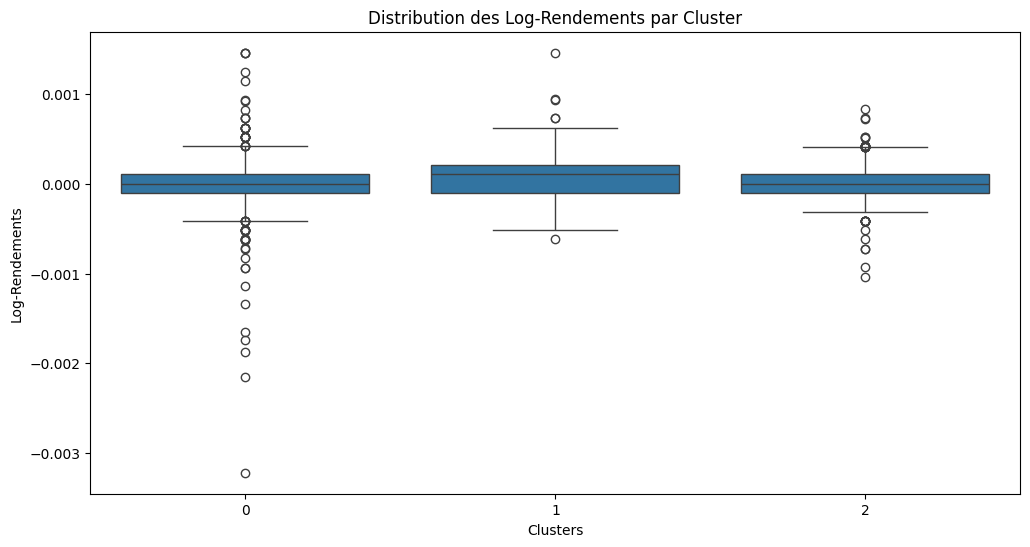

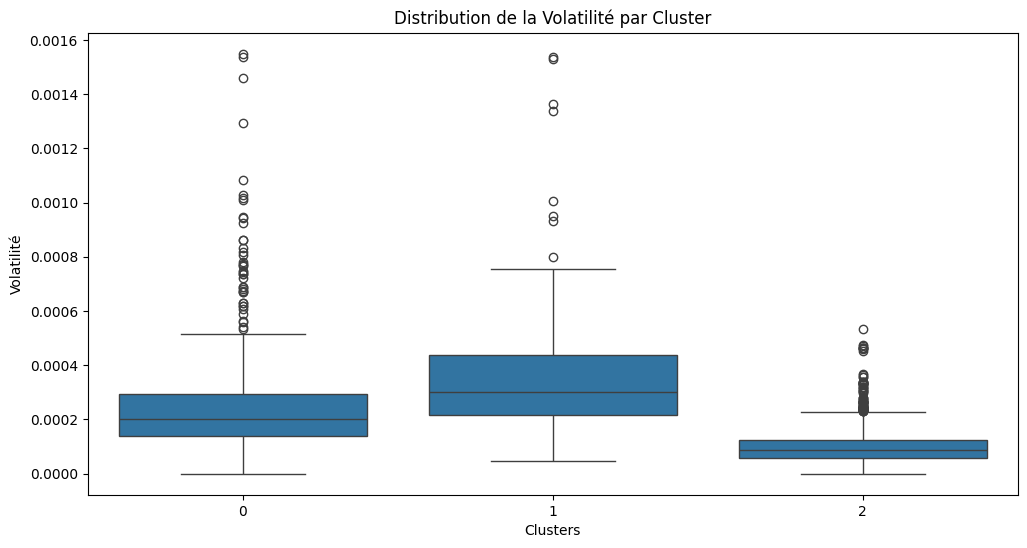

In [ ]:
import seaborn as sns

# Boxplot pour les log-rendements
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Log_Returns', data=combined_data)
plt.title('Distribution des Log-Rendements par Cluster')
plt.xlabel('Clusters')
plt.ylabel('Log-Rendements')
plt.show()

# Boxplot pour la volatilité
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Volatility', data=combined_data)
plt.title('Distribution de la Volatilité par Cluster')
plt.xlabel('Clusters')
plt.ylabel('Volatilité')
plt.show()


### Histogramme des Durées des Régimes
voir combien de temps chaque cluster tend à durer (en nombre de points consécutifs).

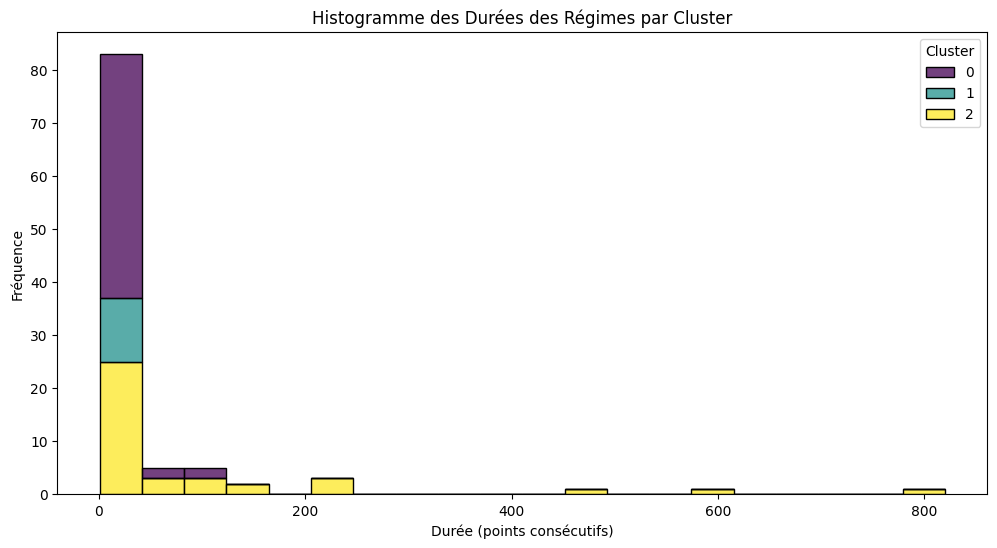

In [ ]:
# Calcul des durées des régimes
combined_data['Duration'] = (combined_data['Cluster'] != combined_data['Cluster'].shift()).cumsum()
durations = combined_data.groupby('Duration').size()
duration_per_cluster = combined_data.groupby(['Duration', 'Cluster']).size().reset_index(name='Count')

# Histogramme des durées par cluster
plt.figure(figsize=(12, 6))
sns.histplot(data=duration_per_cluster, x='Count', hue='Cluster', multiple='stack', bins=20, palette='viridis')
plt.title('Histogramme des Durées des Régimes par Cluster')
plt.xlabel('Durée (points consécutifs)')
plt.ylabel('Fréquence')
plt.show()


# Utilisation du processus stochastique de Merton pour simuler le cours réel avec sa caractéristique "jump" pour simuler les news économiques

In [ ]:
# Fonction de simulation du processus de Merton avec sauts
def simulate_merton_jump_process(S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt):
    """
    Simule un processus de Merton avec sauts pour les prix d'un actif financier.

    Arguments :
    - S0 : Prix initial de l'actif.
    - mu : Rendement moyen.
    - sigma : Volatilité.
    - lambda_jump : Taux de sauts (intensité de Poisson).
    - mu_jump : Moyenne logarithmique des sauts.
    - sigma_jump : Volatilité logarithmique des sauts.
    - T : Durée totale de la simulation (en années).
    - dt : Pas de temps (par exemple, 1/252 pour 1 jour).

    Retour :
    - time_grid : Numpy array des temps simulés.
    - prices : Numpy array des prix simulés.
    """
    n_steps = int(T / dt)
    time_grid = np.linspace(0, T, n_steps)

    # Initialisation des prix
    prices = np.zeros(n_steps)
    prices[0] = S0

    # Simulation des sauts
    jump_counts = np.random.poisson(lambda_jump * dt, n_steps)
    jump_sizes = np.random.normal(mu_jump, sigma_jump, n_steps)
    jump_contribution = jump_counts * jump_sizes

    # Simulation du mouvement brownien
    W = np.random.normal(0, np.sqrt(dt), n_steps)

    # Simulation des prix
    for t in range(1, n_steps):
        prices[t] = prices[t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * W[t] + jump_contribution[t]
        )

    return time_grid, prices

On affiche la simulation pour voir si ça correspond à nos attentes

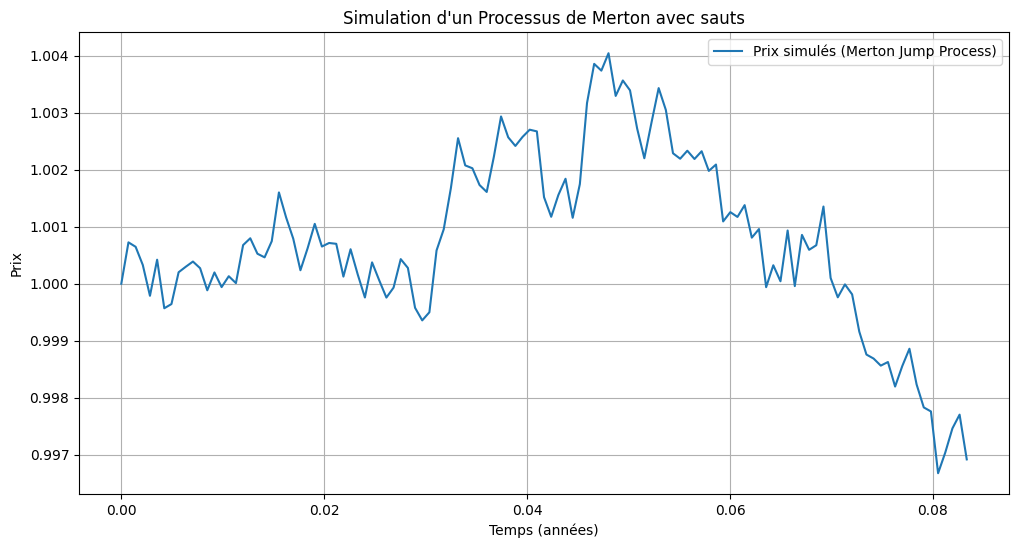

In [ ]:
# Paramètres de simulation
S0 = 1.0  # Prix initial
mu = 0.01  # Rendement moyen
sigma = 0.02  # Volatilité
lambda_jump = 0.1  # Taux de sauts (1 saut toutes les 10 unités de temps en moyenne)
mu_jump = 0.0  # Moyenne des amplitudes des sauts (log-normal)
sigma_jump = 0.05  # Volatilité des sauts
T = 1/12  # Durée totale de la simulation (1 mois)
dt = 1/1440  # Pas de temps (1 minute)

# Simulation
time_grid, prices = simulate_merton_jump_process(S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt)

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(time_grid, prices, label='Prix simulés (Merton Jump Process)')
plt.xlabel('Temps (années)')
plt.ylabel('Prix')
plt.title('Simulation d\'un Processus de Merton avec sauts')
plt.legend()
plt.grid(True)
plt.show()


On a bien un graphe qui change à chaque exécution avec une courbe qui pourrait représenter les marchés financiers

## Backtest avec notre sliced Wasserstein K-means

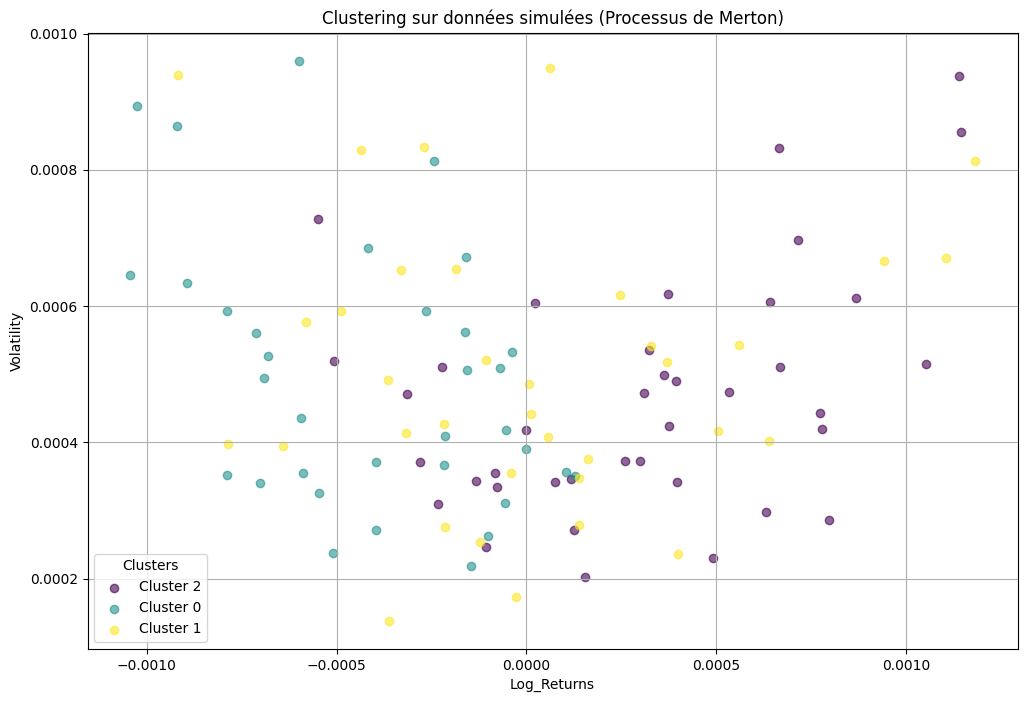

In [ ]:
"""# Simulation des prix avec le processus de Merton
time_grid, simulated_prices = simulate_merton_jump_process(S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt)

# Calcul des log-rendements et de la volatilité
simulated_prices_series = pd.Series(simulated_prices, index=pd.to_datetime(time_grid, unit='D'))
simulated_log_returns = log_returns(simulated_prices_series)
simulated_volatility = realized_volatility(simulated_log_returns)

# Création du DataFrame pour le clustering
simulated_data = pd.concat([simulated_log_returns, simulated_volatility], axis=1).dropna()
simulated_data.columns = ['Log_Returns', 'Volatility']

# Clustering
simulated_for_clustering = simulated_data.values
simulated_labels = sliced_wasserstein_kmeans.fit(simulated_for_clustering)
simulated_data['Cluster'] = simulated_labels

# Visualisation des clusters
visualize_clusters_2d(
    data=simulated_data,
    param1='Log_Returns',
    param2='Volatility',
    cluster_col='Cluster',
    title="Clustering sur données simulées (Processus de Merton)"
)
"""


# Simulation des prix avec le processus de Merton
time_grid, simulated_prices = simulate_merton_jump_process(S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt)

# Calcul des log-rendements et de la volatilité
simulated_prices_series = pd.Series(simulated_prices, index=pd.to_datetime(time_grid, unit='D'))
simulated_log_returns = log_returns(simulated_prices_series)
simulated_volatility = realized_volatility(simulated_log_returns)

# Création du DataFrame pour le clustering
simulated_data = pd.concat([simulated_log_returns, simulated_volatility], axis=1).dropna()
simulated_data.columns = ['Log_Returns', 'Volatility']

# Appliquer le clustering
simulated_for_clustering = simulated_data.values
window_size = 7  # Assurez-vous que cela correspond à la taille des fenêtres définie dans votre SlicedWassersteinKMeans
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=40, window_size=window_size)

# Effectuer le clustering et ajuster les indices
simulated_labels = sliced_wasserstein_kmeans.fit(simulated_for_clustering)
simulated_data = simulated_data.iloc[window_size - 1:]  # Ajuster les indices pour correspondre aux fenêtres
simulated_data['Cluster'] = simulated_labels

# Visualisation des clusters
visualize_clusters_2d(
    data=simulated_data,
    param1='Log_Returns',
    param2='Volatility',
    cluster_col='Cluster',
    title="Clustering sur données simulées (Processus de Merton)"
)


Procédons à l'affichage des régimes directement sur notre processus stochastique

In [ ]:
# Simulation des prix avec le processus de Merton
time_grid, simulated_prices = simulate_merton_jump_process(
    S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt
)

# Conversion en pandas Series pour faciliter l'analyse
simulated_prices_series = pd.Series(simulated_prices, index=pd.to_datetime(time_grid, unit='D'))

# Calcul des log-rendements et de la volatilité
simulated_log_returns = log_returns(simulated_prices_series)
simulated_volatility = realized_volatility(simulated_log_returns)

# Création du DataFrame pour le clustering
simulated_data = pd.concat([simulated_log_returns, simulated_volatility], axis=1).dropna()
simulated_data.columns = ['Log_Returns', 'Volatility']

# Application du clustering
simulated_for_clustering = simulated_data.values
simulated_labels = sliced_wasserstein_kmeans.fit(simulated_for_clustering)
simulated_data['Cluster'] = simulated_labels

# Visualisation des régimes directement sur la courbe des prix
plt.figure(figsize=(15, 8))

# Définir les couleurs pour chaque cluster
colors = {0: 'blue', 1: 'green', 2: 'orange'}

for i in range(len(simulated_prices_series) - 1):
    # Vérifier si l'indice correspond à des données alignées avec les clusters
    if simulated_prices_series.index[i] in simulated_data.index:
        cluster = simulated_data.loc[simulated_prices_series.index[i], 'Cluster']
        plt.plot(
            [simulated_prices_series.index[i], simulated_prices_series.index[i + 1]],
            [simulated_prices_series.iloc[i], simulated_prices_series.iloc[i + 1]],
            color=colors[cluster],
            linewidth=2,
        )

# Ajouter les détails du graphique
plt.title('Identification des Régimes sur la Courbe Simulée (Processus de Merton)')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.grid(True)
plt.legend(
    [plt.Line2D([0], [0], color=color, lw=2) for color in colors.values()],
    [f'Cluster {cluster}' for cluster in colors.keys()],
    title='Régimes'
)
plt.show()


ValueError: Length of values (100) does not match length of index (114)

On se rend compte qu'avec les logs rendements et la volatilités, il nous est
impossible d'identifier clairement des régimes ici

## Essayons d'enrichir les caractéristiques utilisées pour voir si on pourrait avoir de meilleurs résultats

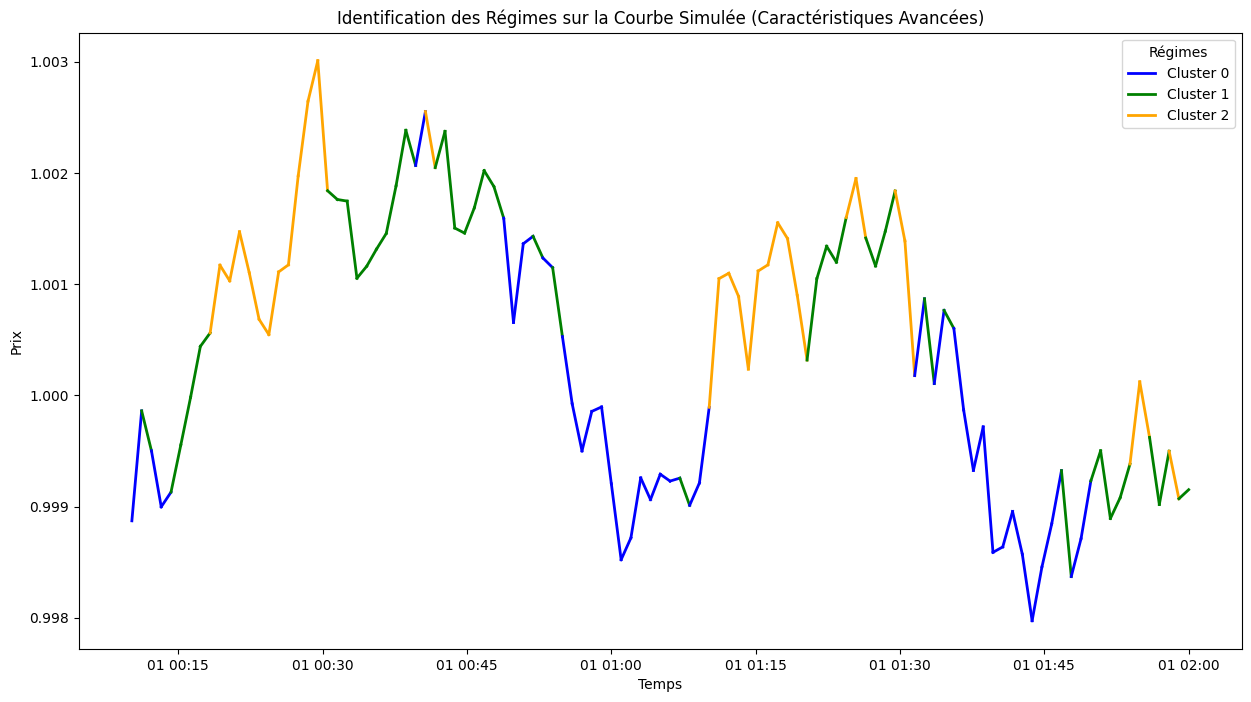

In [ ]:
# Ajout de nouvelles caractéristiques pour voir si on peut mieux identifier les régimes
def calculate_features(data, window=10):
    """
    Calcule des caractéristiques avancées pour enrichir les données.
    """
    features = pd.DataFrame(index=data.index)
    features['Log_Returns'] = log_returns(data)
    features['Volatility'] = realized_volatility(features['Log_Returns'], window)
    features['Cumulative_Returns'] = features['Log_Returns'].rolling(window).sum()
    #features['SMA'] = data.rolling(window).mean()  # Moyenne mobile simple
    features['RSI'] = calculate_rsi(data, window)  # RSI
    features['Momentum'] = data.diff(window)  # Momentum
    features = features.dropna()
    return features

# Calcul du RSI (Relative Strength Index)
def calculate_rsi(data, window=10):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calcul des nouvelles caractéristiques
features = calculate_features(simulated_prices_series, window=10)

# Appliquer le clustering sur les nouvelles caractéristiques
data_for_clustering = features.values
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajouter les clusters aux caractéristiques
features['Cluster'] = labels

# Visualisation des régimes sur la courbe simulée
plt.figure(figsize=(15, 8))
colors = {0: 'blue', 1: 'green', 2: 'orange'}
for i in range(len(simulated_prices_series) - 1):
    if simulated_prices_series.index[i] in features.index:
        cluster = features.loc[simulated_prices_series.index[i], 'Cluster']
        plt.plot(
            [simulated_prices_series.index[i], simulated_prices_series.index[i + 1]],
            [simulated_prices_series.iloc[i], simulated_prices_series.iloc[i + 1]],
            color=colors[cluster],
            linewidth=2,
        )

plt.title('Identification des Régimes sur la Courbe Simulée (Caractéristiques Avancées)')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend(
    [plt.Line2D([0], [0], color=color, lw=2) for color in colors.values()],
    [f'Cluster {cluster}' for cluster in colors.keys()],
    title='Régimes'
)
plt.show()


Exécuter le code juste en-dessous pour changer la courbe sur laquelle on travaille

In [ ]:
"""# Simulation des prix avec le processus de Merton
time_grid, simulated_prices = simulate_merton_jump_process(
    S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt
)

# Conversion en pandas Series pour faciliter l'analyse
simulated_prices_series = pd.Series(simulated_prices, index=pd.to_datetime(time_grid, unit='D'))

# Calcul des log-rendements et de la volatilité
simulated_log_returns = log_returns(simulated_prices_series)
simulated_volatility = realized_volatility(simulated_log_returns)

# Création du DataFrame pour le clustering
simulated_data = pd.concat([simulated_log_returns, simulated_volatility], axis=1).dropna()
simulated_data.columns = ['Log_Returns', 'Volatility']

# Application du clustering
simulated_for_clustering = simulated_data.values
simulated_labels = sliced_wasserstein_kmeans.fit(simulated_for_clustering)
simulated_data['Cluster'] = simulated_labels
"""

# Simulation des prix avec le processus de Merton
time_grid, simulated_prices = simulate_merton_jump_process(
    S0, mu, sigma, lambda_jump, mu_jump, sigma_jump, T, dt
)

# Conversion en pandas Series pour faciliter l'analyse
simulated_prices_series = pd.Series(simulated_prices, index=pd.to_datetime(time_grid, unit='D'))

# Calcul des log-rendements et de la volatilité
simulated_log_returns = log_returns(simulated_prices_series)
simulated_volatility = realized_volatility(simulated_log_returns)

# Création du DataFrame pour le clustering
simulated_data = pd.concat([simulated_log_returns, simulated_volatility], axis=1).dropna()
simulated_data.columns = ['Log_Returns', 'Volatility']

# Application du clustering
simulated_for_clustering = simulated_data.values

# Taille de la fenêtre utilisée dans le clustering
window_size = 7  # Assurez-vous que cette valeur correspond à celle définie dans votre SlicedWassersteinKMeans
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=40, window_size=window_size)

# Clustering et ajustement des indices
simulated_labels = sliced_wasserstein_kmeans.fit(simulated_for_clustering)
simulated_data = simulated_data.iloc[window_size - 1:]  # Ajuster les indices
simulated_data['Cluster'] = simulated_labels

# Vérification
print(simulated_data.head())


                               Log_Returns  Volatility  Cluster
1970-01-01 00:11:11.186440676    -0.000845    0.000776        1
1970-01-01 00:12:12.203389831     0.000810    0.000822        2
1970-01-01 00:13:13.220338987    -0.000620    0.000779        0
1970-01-01 00:14:14.237288134    -0.000401    0.000642        1
1970-01-01 00:15:15.254237289     0.000562    0.000738        2


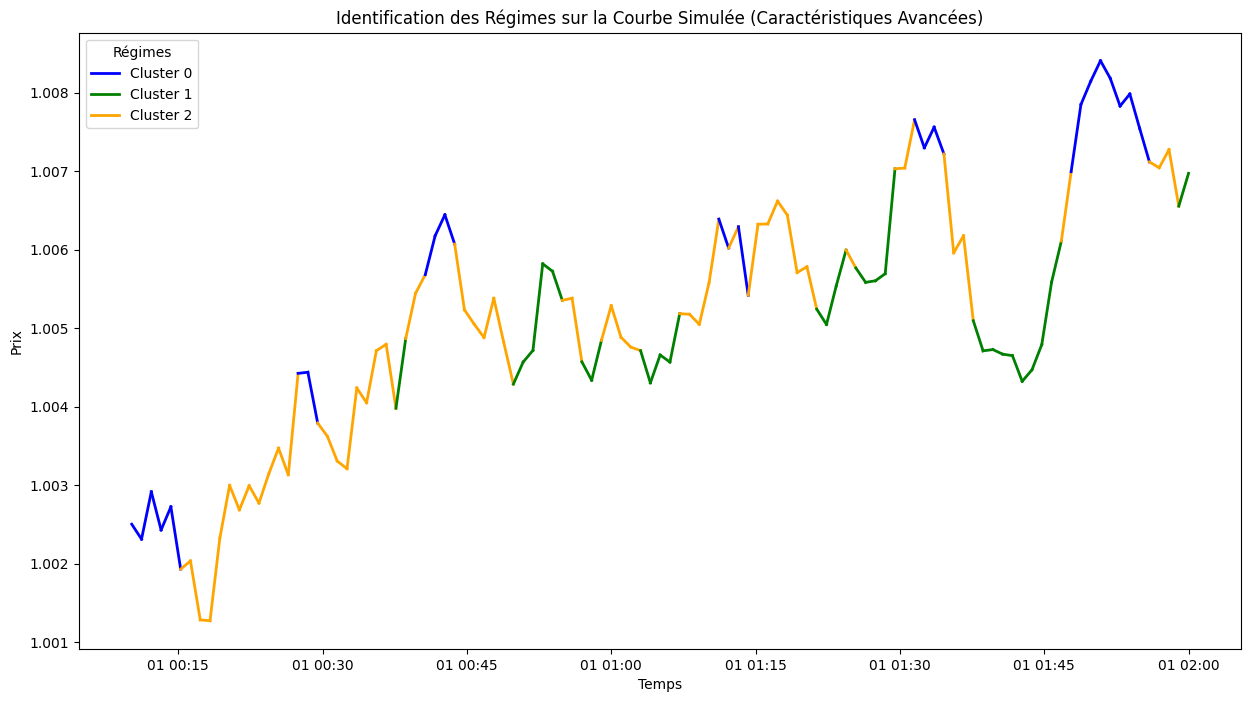

In [ ]:
# Ajout de nouvelles caractéristiques pour voir si on peut mieux identifier les régimes
def calculate_features(data, window=10):
    """
    Calcule des caractéristiques avancées pour enrichir les données.
    """
    features = pd.DataFrame(index=data.index)
    features['Log_Returns'] = log_returns(data)
    features['Volatility'] = realized_volatility(features['Log_Returns'], window)
    #features['Cumulative_Returns'] = features['Log_Returns'].rolling(window).sum()
    #features['Momentum'] = momentum(data, window)
    features['RSI'] = calculate_rsi(data, window)
    features['Return/Volatility'] = return_volatility_ratio(
        features['Log_Returns'], features['Volatility']
    )
    features['Jump_Count'] = jump_detection(features['Log_Returns'], threshold=0.001)
    features['Tick_Count'] = tick_count(data, window)
    features['Upper_Band'], features['Lower_Band'] = bollinger_bands(data, window)
    features = features.dropna()
    return features

# Vol
def realized_volatility(data, window=5):
    return data.rolling(window).std().dropna()


# Calcul du RSI (Relative Strength Index)
def calculate_rsi(data, window=5):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Momentum
def momentum(data, window=5):
    return data.diff(window)


#Calcul bande de bollinger
def bollinger_bands(data, window=5, num_std_dev=2):
    sma_data = data.rolling(window).mean()
    std_dev = data.rolling(window).std()
    upper_band = sma_data + num_std_dev * std_dev
    lower_band = sma_data - num_std_dev * std_dev
    return upper_band, lower_band


#Ratio Log-Rendement/Volatilité à très court terme
def return_volatility_ratio(log_returns, volatility):
    return log_returns / volatility


#Détection de Sauts à Haute Fréquence
def jump_detection(data, threshold=0.001):
    jumps = (data.diff().abs() > threshold).astype(int)
    return jumps.rolling(window=5).sum()  # Nombre de sauts sur 5 minutes

#Tick Count
def tick_count(data, window=5):
    return data.diff().abs().rolling(window).count()



# Calcul des nouvelles caractéristiques
features = calculate_features(simulated_prices_series, window=10)

# Appliquer le clustering sur les nouvelles caractéristiques
data_for_clustering = features.values
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajouter les clusters aux caractéristiques
features['Cluster'] = labels

# Visualisation des régimes sur la courbe simulée
plt.figure(figsize=(15, 8))
colors = {0: 'blue', 1: 'green', 2: 'orange'}
for i in range(len(simulated_prices_series) - 1):
    if simulated_prices_series.index[i] in features.index:
        cluster = features.loc[simulated_prices_series.index[i], 'Cluster']
        plt.plot(
            [simulated_prices_series.index[i], simulated_prices_series.index[i + 1]],
            [simulated_prices_series.iloc[i], simulated_prices_series.iloc[i + 1]],
            color=colors[cluster],
            linewidth=2,
        )

plt.title('Identification des Régimes sur la Courbe Simulée (Caractéristiques Avancées)')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend(
    [plt.Line2D([0], [0], color=color, lw=2) for color in colors.values()],
    [f'Cluster {cluster}' for cluster in colors.keys()],
    title='Régimes'
)
plt.show()


<ipython-input-40-72dce5673319>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = labels


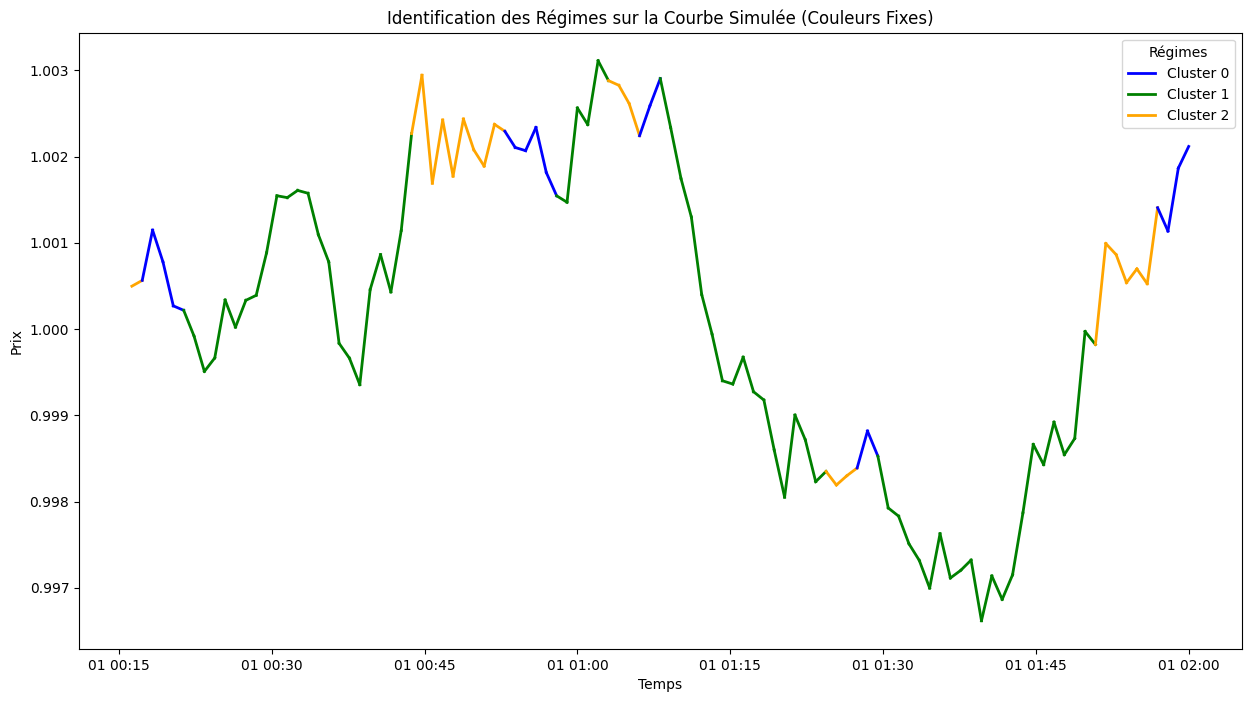

In [ ]:
# Ajout de nouvelles caractéristiques pour voir si on peut mieux identifier les régimes
def calculate_features(data, window=10):
    """
    Calcule des caractéristiques avancées pour enrichir les données.
    """
    features = pd.DataFrame(index=data.index)
    features['Log_Returns'] = log_returns(data)
    features['Volatility'] = realized_volatility(features['Log_Returns'], window)
    features['Cumulative_Returns'] = features['Log_Returns'].rolling(window).sum()
    #features['Momentum'] = momentum(data, window)
    #features['RSI'] = calculate_rsi(data, window)
    #features['Return/Volatility'] = return_volatility_ratio(
    #    features['Log_Returns'], features['Volatility']
    #)
    features['Jump_Count'] = jump_detection(features['Log_Returns'], threshold=0.001)
    #features['Tick_Count'] = tick_count(data, window)
    #features['Upper_Band'], features['Lower_Band'] = bollinger_bands(data, window)
    features = features.dropna()
    return features

# Vol
def realized_volatility(data, window=5):
    return data.rolling(window).std().dropna()

# Calcul du RSI (Relative Strength Index)
def calculate_rsi(data, window=5):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Momentum
def momentum(data, window=5):
    return data.diff(window)

# Calcul bande de bollinger
def bollinger_bands(data, window=5, num_std_dev=2):
    sma_data = data.rolling(window).mean()
    std_dev = data.rolling(window).std()
    upper_band = sma_data + num_std_dev * std_dev
    lower_band = sma_data - num_std_dev * std_dev
    return upper_band, lower_band

# Ratio Log-Rendement/Volatilité à très court terme
def return_volatility_ratio(log_returns, volatility):
    return log_returns / volatility

# Détection de Sauts à Haute Fréquence
def jump_detection(data, threshold=0.001):
    jumps = (data.diff().abs() > threshold).astype(int)
    return jumps.rolling(window=5).sum()  # Nombre de sauts sur 5 minutes

# Tick Count
def tick_count(data, window=5):
    return data.diff().abs().rolling(window).count()
"""
# Calcul des nouvelles caractéristiques
features = calculate_features(simulated_prices_series, window=10)

# Appliquer le clustering sur les nouvelles caractéristiques
data_for_clustering = features.values
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajouter les clusters aux caractéristiques
features['Cluster'] = labels

# Fixer les couleurs pour les clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'orange'}  # Couleurs fixes pour chaque cluster

# Visualisation des régimes sur la courbe simulée
plt.figure(figsize=(15, 8))

for i in range(len(simulated_prices_series) - 1):
    if simulated_prices_series.index[i] in features.index:
        cluster = features.loc[simulated_prices_series.index[i], 'Cluster']
        color = cluster_colors[cluster]  # Couleur fixe pour chaque cluster
        plt.plot(
            [simulated_prices_series.index[i], simulated_prices_series.index[i + 1]],
            [simulated_prices_series.iloc[i], simulated_prices_series.iloc[i + 1]],
            color=color,
            linewidth=2,
        )

plt.title('Identification des Régimes sur la Courbe Simulée (Couleurs Fixes)')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend(
    [plt.Line2D([0], [0], color=color, lw=2) for color in cluster_colors.values()],
    [f'Cluster {cluster}' for cluster in cluster_colors.keys()],
    title='Régimes'
)
plt.show()
"""

# Calcul des nouvelles caractéristiques
features = calculate_features(simulated_prices_series, window=10)

# Appliquer le clustering sur les nouvelles caractéristiques
data_for_clustering = features.values

# Taille de la fenêtre utilisée dans le clustering
window_size = 10  # Doit correspondre à la fenêtre utilisée pour calculer les caractéristiques

# Clustering
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajustement des indices pour correspondre à la longueur des labels
features = features.iloc[-len(labels):]  # Ajuster pour correspondre exactement à la longueur des labels
features['Cluster'] = labels

# Fixer les couleurs pour les clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'orange'}  # Couleurs fixes pour chaque cluster

# Visualisation des régimes sur la courbe simulée
plt.figure(figsize=(15, 8))

for i in range(len(simulated_prices_series) - 1):
    if simulated_prices_series.index[i] in features.index:
        cluster = features.loc[simulated_prices_series.index[i], 'Cluster']
        color = cluster_colors[cluster]  # Couleur fixe pour chaque cluster
        plt.plot(
            [simulated_prices_series.index[i], simulated_prices_series.index[i + 1]],
            [simulated_prices_series.iloc[i], simulated_prices_series.iloc[i + 1]],
            color=color,
            linewidth=2,
        )

plt.title('Identification des Régimes sur la Courbe Simulée (Couleurs Fixes)')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend(
    [plt.Line2D([0], [0], color=color, lw=2) for color in cluster_colors.values()],
    [f'Cluster {cluster}' for cluster in cluster_colors.keys()],
    title='Régimes'
)
plt.show()

